In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
pathMain = 'API_19_DS2_en_excel_v2_6002116.xls'
pathGDP =  "API_NY.GDP.MKTP.CD_DS2_en_excel_v2_5994847.xls"
pathGDPcap = "API_NY.GDP.PCAP.CD_DS2_en_excel_v2_5994922.xls"

In [6]:


def dataInitialize(mainData, GDPdir, GDPCapDir): 

    #Reads the data file and takes out all the sheets from it
    dfData = pd.read_excel(mainData, header = 3)
    dfGDP = pd.read_excel(GDPdir, header = 3)
    dfGDPcap = pd.read_excel(GDPCapDir, header = 3)
    dfCountryMetaData = pd.read_excel(mainData, sheet_name = 'Metadata - Countries')

    #Merged columns from Data and Country MetaData
    dfDataMerged = pd.merge(dfData, dfCountryMetaData, on = 'Country Code', how = 'inner')
    dfDataMerged = pd.concat([dfDataMerged, dfGDP, dfGDPcap], axis = 0).sort_values(by = 'Country Name', ascending = True)
    dfDataMerged = dfDataMerged.reset_index()

    #Filling in NaN Regions and IncomeGroups with respective values
    region_list = {}
    income_list = {}
    for i in dfCountryMetaData['TableName'].unique():
        region_list[i] = dfCountryMetaData[dfCountryMetaData['TableName'] == i]['Region'].unique()[0]
        income_list[i] = dfCountryMetaData[dfCountryMetaData['TableName'] == i]['IncomeGroup'].unique()[0]

    for i, j in region_list.items():
        dfDataMerged.loc[dfDataMerged['Country Name'] == i, 'Region'] = j
        dfDataMerged.loc[dfDataMerged['Country Name'] == i, 'IncomeGroup'] = j

    #Sorting Columns out, changing column positions to start of df and removing unwanted columns
    columnslist = dfDataMerged.columns.tolist()
    columnslist.insert(4,columnslist.pop(dfDataMerged.columns.get_loc('Region')))
    columnslist.insert(5,columnslist.pop(dfDataMerged.columns.get_loc('IncomeGroup')))
    dfDataMerged = dfDataMerged[columnslist]
    dfDataMerged = dfDataMerged.drop(columns = ['SpecialNotes', 'TableName', 'index'], axis = 1)

    #Setting Multilevel Index for df (dfCountry)
    dfCountry = dfDataMerged.set_index(['Country Name', 'Country Code', 'Region', 'IncomeGroup', 'Indicator Code', 'Indicator Name'])

    #Filtering out columns based on Indicators I want to look at. Filter Indicators and Countries here.
    dfCountry = dfCountry[dfCountry.index.get_level_values('Country Name')
    .isin(['India', 'China', 'Russian Federation', 'Australia', 'Nigeria', 'Ghana', 
           'Kenya', 'Brazil', 'Mexico', 'Argentina', 'United States', 'Turkiye', 'Germany', 'France', 'United Kingdom'])]

    #This is where the function to output two dataframes ends
    dfYear = dfCountry.T
    
    return dfCountry, dfYear



In [7]:
dfCountry, dfYear = dataInitialize(pathMain, pathGDP, pathGDPcap)

In [61]:
#CREATING DATAFRAMES FOR ALL VISUALIZATIONS
  
dfTimeSeries = dfCountry.loc[pd.IndexSlice[:, :, :, :, ('NY.GDP.MKTP.CD'), :] , :]

dfPopulationTotal = dfCountry.loc[pd.IndexSlice[:, :, :, :, ('SP.POP.TOTL'), :], :]
   
dfPopulationGrowth = dfCountry.loc[pd.IndexSlice[:, :, :, :, ('SP.POP.GROW'), :], :]

dfUrbanAgglo = dfCountry.loc[pd.IndexSlice[:, :, :, :, ('EN.URB.MCTY.TL.ZS'), :], :]

dfUrbanPopulation = dfCountry.loc[pd.IndexSlice[:, :, :, :, ('SP.URB.TOTL'), :], :]

dfGDPCapita = dfCountry.loc[pd.IndexSlice[:, :, :, :, ('NY.GDP.PCAP.CD'), :], :]

dfEnergy = dfCountry.loc[pd.IndexSlice[:, :, :, :, ('EG.USE.ELEC.KH.PC'), :], :]

dfEnergySources = dfCountry.loc[pd.IndexSlice[('United States','China','India','Ghana','Mexico','Russian Federation'), :, :, :, ('EG.ELC.PETR.ZS','EG.ELC.NGAS.ZS','EG.ELC.COAL.ZS'), :], :]  

dfForestLand = dfCountry.loc[pd.IndexSlice[:, :, :, :, ('AG.LND.FRST.K2'), :], :]  

dfgreenhouse = dfCountry.loc[pd.IndexSlice[:, :, :, :, ('EN.ATM.GHGT.KT.CE'), :], :]  



In [62]:
dfTimeSeries.reset_index(inplace = True)
dfPopulationTotal.reset_index(inplace = True)
dfPopulationGrowth.reset_index(inplace = True)
dfUrbanAgglo.reset_index(inplace = True)
dfUrbanPopulation.reset_index(inplace = True)
dfGDPCapita.reset_index(inplace = True)
dfEnergy.reset_index(inplace = True)
dfEnergySources.reset_index(inplace = True)
dfgreenhouse.reset_index(inplace = True)
dfForestLand.reset_index(inplace = True)

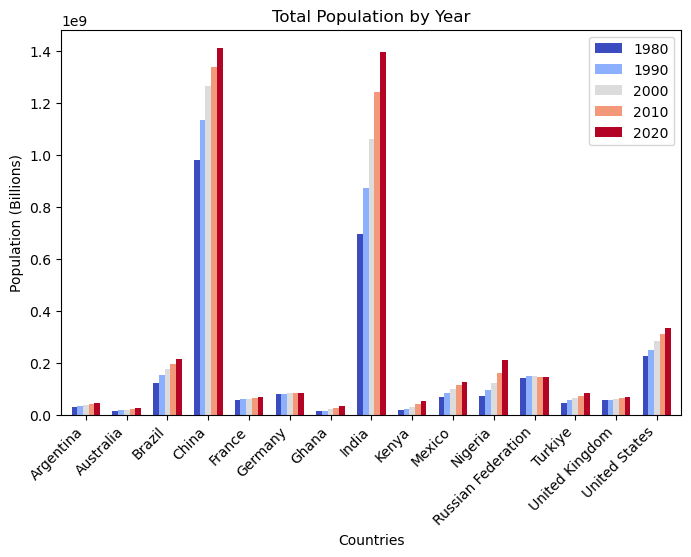

In [101]:
dfPopTotal = pd.melt(dfPopulationTotal, id_vars = ['Country Name', 'Indicator Name'], value_vars = [str(x) for x in range(1980, 2021, 10)])
dfPopTotal.pivot(index = ['Country Name'], columns = 'variable', values = 'value').plot(kind = 'bar', width = 0.7, figsize = (8, 5), colormap = 'coolwarm')

plt.xlabel('Countries')
plt.ylabel('Population (Billions)')
plt.title('Total Population by Year')
plt.xticks(rotation = 45, ha = 'right')
plt.legend()
plt.show()

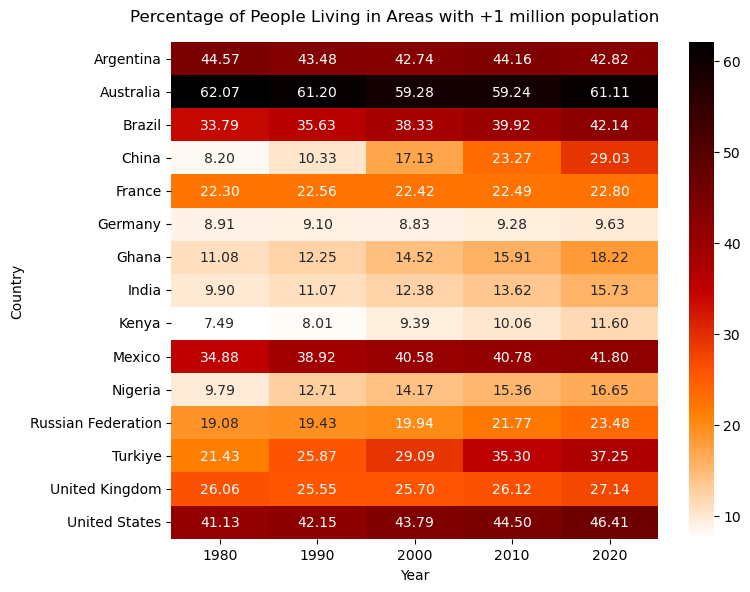

In [47]:
dfAgglo = pd.melt(dfUrbanAgglo, id_vars = ['Country Name', 'Indicator Name'], value_vars = [str(x) for x in range(1980, 2021, 10)])
AggloPivot = dfAgglo.pivot_table(index = 'Country Name', columns = 'variable', values = 'value')

fig, axs = plt.subplots(figsize = (8, 6))
sns.heatmap(AggloPivot, annot = True, fmt = ".2f", cmap = "gist_heat_r")

plt.suptitle('Percentage of People Living in Areas with +1 million population')
axs.set_xlabel('Year')
axs.set_ylabel('Country')
plt.tight_layout()
plt.show()

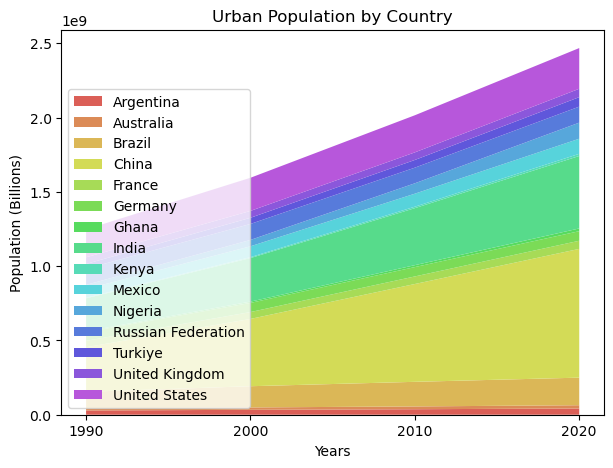

In [52]:
dfUrbPop = pd.melt(dfUrbanPopulation, id_vars = ['Country Name', 'Indicator Name'], value_vars = [str(x) for x in range(1990, 2021, 10)])
UrbPopPivot = dfUrbPop.pivot_table(index = 'Country Name', columns = 'variable', values = 'value')

plt.figure(figsize = (7, 5))

years = UrbPopPivot.columns
values = UrbPopPivot.values

pallete = sns.color_palette('hls', 18)

plt.stackplot(years, values, labels = UrbPopPivot.index, colors = pallete)

plt.xlabel('Years')
plt.ylabel('Population (Billions)')
plt.title('Urban Population by Country')
plt.legend(loc='lower left')

plt.show()

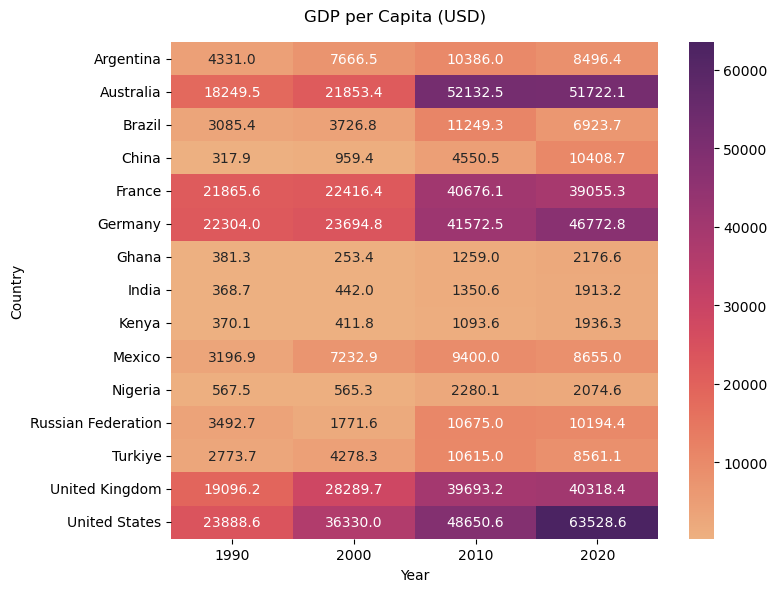

In [93]:
dfGDPcap = pd.melt(dfGDPCapita, id_vars = ['Country Name', 'Indicator Name'], value_vars = [str(x) for x in range(1990, 2021, 10)])
GDPCapPivot = dfGDPcap.pivot_table(index = 'Country Name', columns = 'variable', values = 'value')

fig, axs = plt.subplots(figsize = (8, 6))
sns.heatmap(GDPCapPivot, annot = True, fmt = ".1f", cmap = "flare")

plt.suptitle('GDP per Capita (USD)')
# axs.set_title('Heatmap')
axs.set_xlabel('Year')
axs.set_ylabel('Country')
plt.tight_layout()
plt.show()


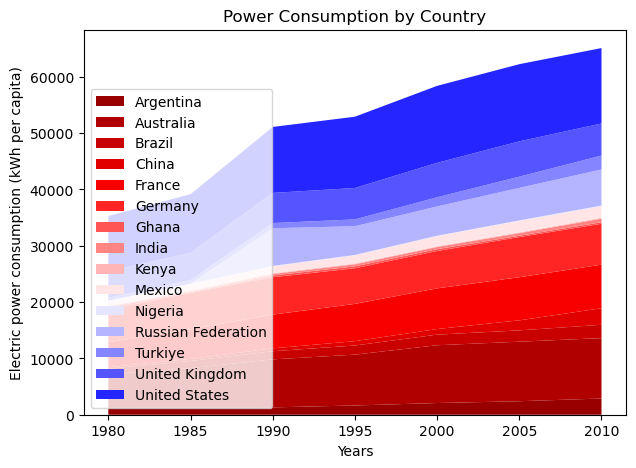

In [85]:
dfEnergyC = pd.melt(dfEnergy, id_vars = ['Country Name', 'Indicator Name'], value_vars = [str(x) for x in range(1980, 2015, 5)])
dfEnergyC = dfEnergyC.groupby(['Country Name', 'variable'])['value'].sum().reset_index()
EnergyPivot = dfEnergyC.pivot_table(index = 'Country Name', columns = 'variable', values = 'value')

plt.figure(figsize = (7, 5))

years = EnergyPivot.columns
values = EnergyPivot.values
pallete = sns.color_palette('seismic_r', 20)

plt.stackplot(years, values, labels = EnergyPivot.index, colors = pallete)

plt.xlabel('Years')
plt.ylabel('Electric power consumption (kWh per capita)')
plt.title('Power Consumption by Country')
plt.legend(loc='lower left')

plt.show()

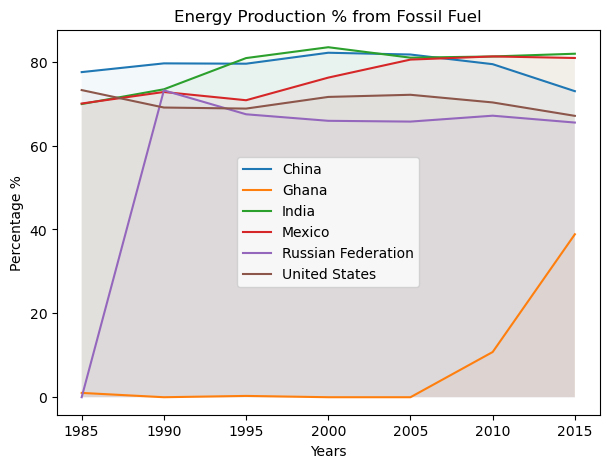

In [72]:
dfEnergySRC = pd.melt(dfEnergySources, id_vars = ['Country Name', 'Indicator Name', 'Region'], value_vars = [str(x) for x in range(1985, 2016, 5)])
dfEnergySRC = dfEnergySRC.groupby(['Country Name', 'variable'])['value'].sum().reset_index()
EnergySRCPivot = dfEnergySRC.pivot_table(index = 'Country Name', columns = 'variable', values = 'value')

plt.figure(figsize = (7, 5))

line_data = EnergySRCPivot.transpose()

for country in line_data.columns:
    plt.plot(line_data.index, line_data[country], label=country)
    plt.fill_between(line_data.index, line_data[country], alpha = 0.05)

plt.xlabel('Years')
plt.ylabel('Percentage %')
plt.title('Energy Production % from Fossil Fuel')
plt.legend() 

plt.show()


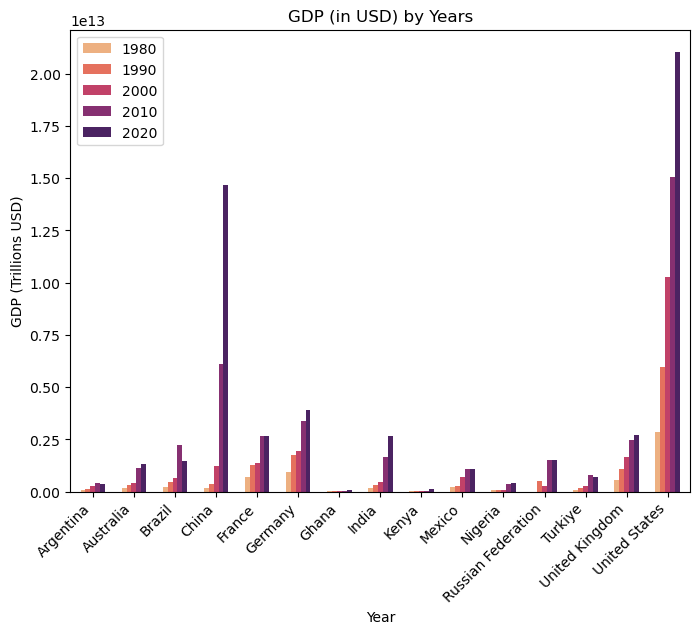

In [80]:
#plot for GDP for each country by years

dfGDP = pd.melt(dfTimeSeries, id_vars = ['Country Name', 'Indicator Name'], value_vars = [str(x) for x in range(1980, 2021, 10)])
dfGDP.pivot(index = 'Country Name', columns = 'variable', values = 'value').plot(kind = 'bar', width=0.6, figsize = (8, 6), colormap = 'flare')

plt.xlabel('Year')
plt.ylabel('GDP (Trillions USD)')
plt.title('GDP (in USD) by Years')
plt.xticks(rotation = 45, ha = 'right')
plt.legend()
plt.show()


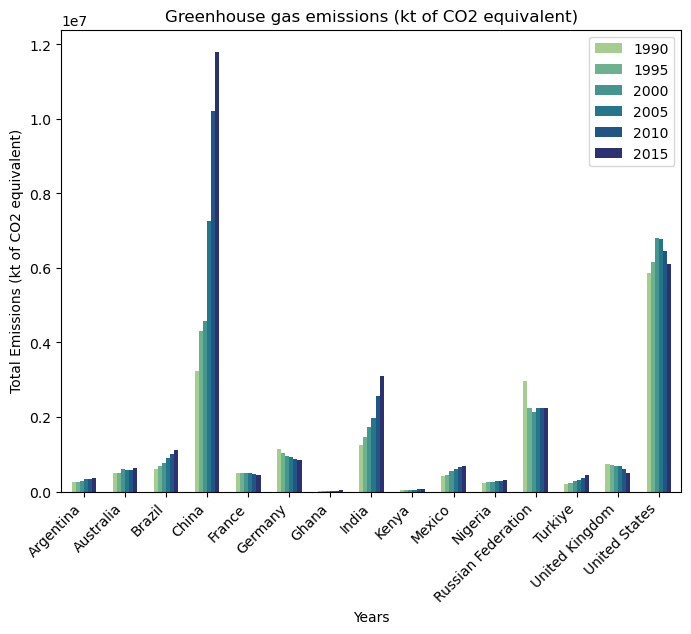

In [81]:
dfGHG = pd.melt(dfgreenhouse, id_vars = ['Country Name', 'Indicator Name', 'Region'], value_vars = [str(x) for x in range(1990, 2016, 5)])
GHGPivot = dfGHG.pivot_table(index ='Country Name', columns = 'variable', values = 'value').plot(kind = 'bar', width=0.6, figsize = (8, 6), colormap = 'crest')


plt.xlabel('Years')
plt.ylabel('Total Emissions (kt of CO2 equivalent)')
plt.title('Greenhouse gas emissions (kt of CO2 equivalent)')
plt.xticks(rotation = 45, ha = 'right')
plt.legend()
plt.show()